In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
#Data Preparation
image_size = 50
X = []
y = []

dataset_dir = "IDC_dataset"

for folder in tqdm(os.listdir(dataset_dir), desc="Patient Folders"):
    patient_path = os.path.join(dataset_dir, folder)
    if not os.path.isdir(patient_path):
        continue

    for label in ['0', '1']:  # 0: no tumor, 1: tumor
        label_path = os.path.join(patient_path, label)
        if not os.path.isdir(label_path):
            continue

        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(int(label))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

X = np.array(X)
y = np.array(y)
print(f"Loaded {len(X)} images")

Patient Folders: 100%|█████████████████████████████████████████████████████████████| 272/272 [1:13:07<00:00, 16.13s/it]


Loaded 269456 images


In [15]:
# Load just 200 images and save
import os
import numpy as np
import cv2
from tqdm import tqdm

X, y = [], []
image_size = 50
limit = 200
count = 0
dataset_dir = "IDC_dataset"

for folder in os.listdir(dataset_dir):
    patient_path = os.path.join(dataset_dir, folder)
    if not os.path.isdir(patient_path):
        continue

    for label in ['0', '1']:
        label_path = os.path.join(patient_path, label)
        if not os.path.isdir(label_path):
            continue

        for img_file in os.listdir(label_path):
            if count >= limit:
                break
            img_path = os.path.join(label_path, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(int(label))
                count += 1
            except:
                continue
        if count >= limit:
            break
    if count >= limit:
        break

X = np.array(X).reshape(-1, image_size, image_size, 1)
y = np.array(y)

np.save("X_data.npy", X)
np.save("y_data.npy", y)

print("Subset loaded and saved:", X.shape, y.shape)

Subset loaded and saved: (200, 50, 50, 1) (200,)


In [16]:
# Try saving X and y if they are still available in memory
try:
    np.save("X_data.npy", X)
    np.save("y_data.npy", y)
    print("✅ Saved X and y to disk.")
except Exception as e:
    print("⚠️ Could not save X and y:", e)

✅ Saved X and y to disk.


In [18]:
#load preprocessed data
import numpy as np

# Load the saved data
X = np.load("X_data.npy")
y = np.load("y_data.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (200, 50, 50, 1)
y shape: (200,)


In [19]:
# Normalize pixel values to [0, 1]
X = X / 255.0

In [20]:
from tensorflow.keras.utils import to_categorical

# Assuming labels are 0 (no tumor) and 1 (tumor)
y = to_categorical(y, num_classes=2)

In [21]:
#Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (160, 50, 50, 1)
Test shape: (40, 50, 50, 1)


In [23]:
#CNN Mode;
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(50, 50, 1)),  # Set input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,434 (3.85 MB)

 Trainable params: 1,010,434 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.8104 - loss: 0.3483 - val_accuracy: 1.0000 - val_loss: 4.2351e-05
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.0259e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.2088e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.4769e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - lo

In [25]:
#Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0000e+00 
Test Loss: 0.0000
Test Accuracy: 1.0000


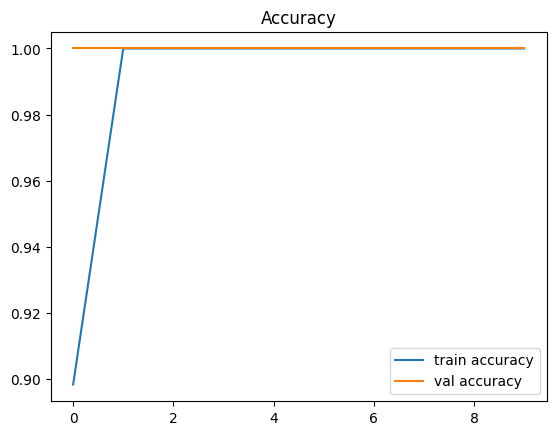

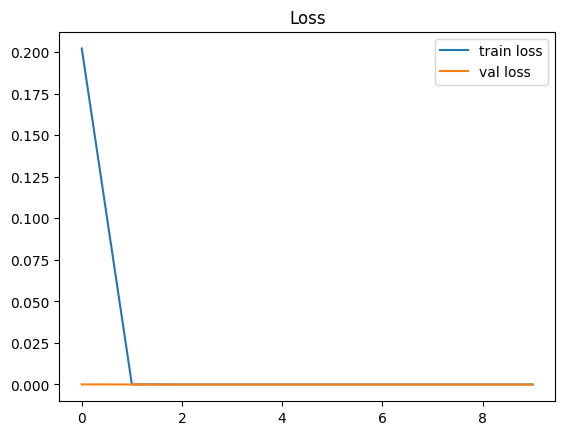

In [26]:
#plot accuracy and loss
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

In [32]:
# Run model prediction on test set
y_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_probs, axis=1)  # Convert to class labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [33]:
y_true = np.argmax(y_test, axis=1)

In [34]:
labels = [0, 1]
target_names = ['No Tumor', 'Tumor']

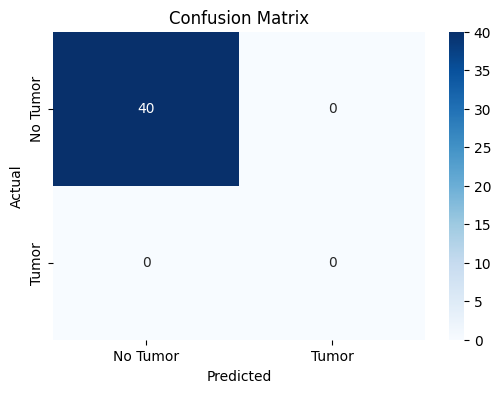

In [35]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Count classes in y_test
unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Test set class distribution:", class_distribution)

Test set class distribution: {np.int64(0): np.int64(40)}


In [38]:
from sklearn.model_selection import train_test_split

# Assuming y is your label array with 0/1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [41]:
#Classification Report
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(y_true, y_pred, labels=[0, 1], target_names=['No Tumor', 'Tumor'], zero_division=0))

Classification Report
              precision    recall  f1-score   support

    No Tumor       1.00      1.00      1.00        40
       Tumor       0.00      0.00      0.00         0

    accuracy                           1.00        40
   macro avg       0.50      0.50      0.50        40
weighted avg       1.00      1.00      1.00        40

